# West-East receiver function profile in Northern Chile

This notebook demonstrates receiver function calculation and profile stacking with the help of the [rf](https://github.com/trichter/rf) package using [IPOC](http://www.ipoc-network.org/) data from Northern Chile.

If you want to run this notebook locally, have a look at the repository [readme](https://github.com/trichter/notebooks).
Dependencies of this notebook are ObsPy, rf, h5py, obspyh5, and tqdm.

First we import the necessary functions and define file names for the inventory, earthquake and waveform files.

In [1]:
import os.path

%matplotlib inline
from obspy import read_inventory, read_events, UTCDateTime as UTC
from obspy.clients.fdsn import Client
from rf import read_rf, RFStream
from rf import get_profile_boxes, iter_event_data, IterMultipleComponents
from rf.imaging import plot_profile_map
from rf.profile import profile
from tqdm import tqdm

invfile = 'rfprofile_stations.xml'
catfile = 'rfprofile_events.xml'
datafile = 'rfprofile_data.h5'
rffile = 'rfprofile_rfs.h5'
profilefile = 'rfprofile.h5'

Inventory data and events of the year 2010 with magnitude between 5.5 and 6.5 are downloaded if necessary and plotted.

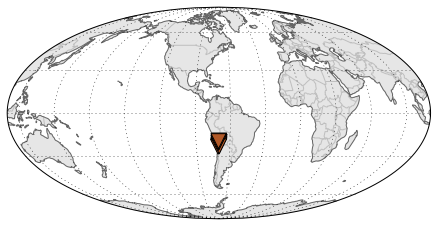

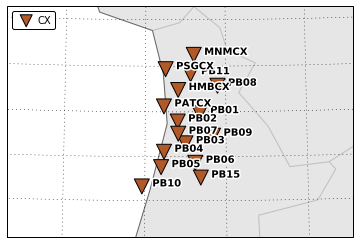

In [2]:
if not os.path.exists(invfile):
    client = Client('GFZ')
    inventory = client.get_stations(network='CX', channel='BH?', level='channel',
                                    minlatitude=-24, maxlatitude=-19)
    inventory.write(invfile, 'STATIONXML')
inventory = read_inventory(invfile)
inventory.plot(label=False)
fig = inventory.plot('local', color_per_network=True)

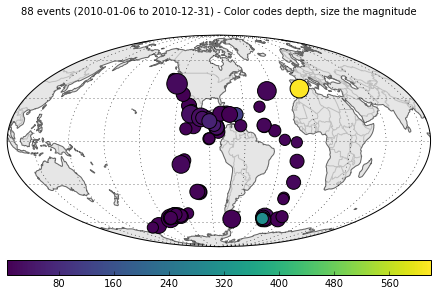

In [3]:
coords = inventory.get_coordinates('CX.PB01..BHZ')
lonlat = (coords['longitude'], coords['latitude'])
if not os.path.exists(catfile):
    client = Client()
    kwargs = {'starttime': UTC('2010-01-01'), 'endtime': UTC('2011-01-01'), 
              'latitude': lonlat[1], 'longitude': lonlat[0],
              'minradius': 30, 'maxradius': 90,
              'minmagnitude': 5.5, 'maxmagnitude': 6.5}
    catalog = client.get_events(**kwargs)
    catalog.write(catfile, 'QUAKEML')
catalog = read_events(catfile)
fig = catalog.plot(label=None, show=False) 

Then, we download the waveform data with the `iter_event_data` iterator and save it to a `HDF5` file. The iterator automatically inserts the necessary headers into the stream by applying the `rfstats` function.

In [4]:
if not os.path.exists(datafile):
    client = Client('GFZ')
    stream = RFStream()
    with tqdm() as pbar:
        for s in iter_event_data(catalog, inventory, client.get_waveforms, pbar=pbar):
            stream.extend(s)
    stream.write(datafile, 'H5')    

We read the data again and iterate through it using `IterMultipleComponents`. This iterator returns a three component stream for each event and station. We filter the data, trim it relative to the P onset, calculate receiver functions and apply Ps moveout correction. After that the L component of one station and the Q component of some stations are plotted. The L component of the receiver function shows the expected peak at 0s.

In [5]:
data = read_rf(datafile, 'H5')
stream = RFStream()
for stream3c in tqdm(IterMultipleComponents(data, 'onset', 3)):
    stream3c.filter('bandpass', freqmin=0.5, freqmax=2)
    stream3c.trim2(-25, 75, 'onset')
    if len(stream3c) != 3:
        continue
    stream3c.rf()
    stream3c.moveout()
    stream.extend(stream3c)
stream.write(rffile, 'H5')
print stream

3273 Trace(s) in Stream:

Prf CX.HMBCX..BHL | -25.0s - 75.0s onset:2010-01-27T17:52:02.949998Z | 20.0 Hz, 2001 samples | mag:5.8 dist:53.1 baz:92.8 slow:6.40 (Ps moveout)
...
(3271 other traces)
...
Prf CX.PSGCX..BHT | -25.0s - 75.0s onset:2010-12-31T16:39:31.150000Z | 20.0 Hz, 2001 samples | mag:5.5 dist:47.7 baz:70.2 slow:6.40 (Ps moveout)

[Use "print(Stream.__str__(extended=True))" to print all Traces]


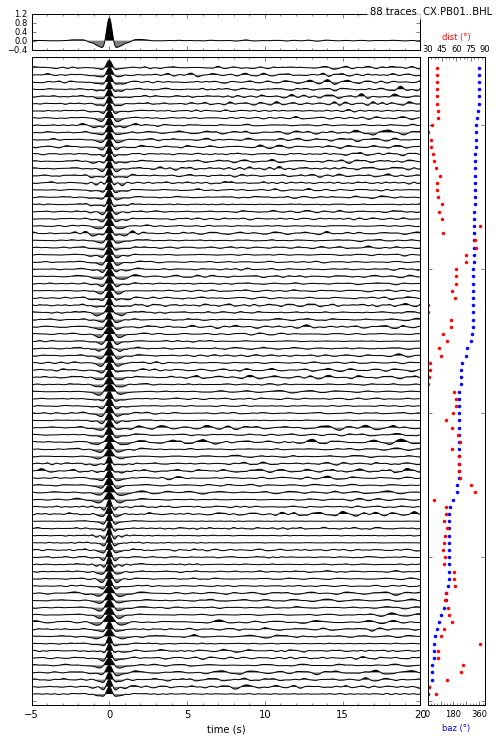

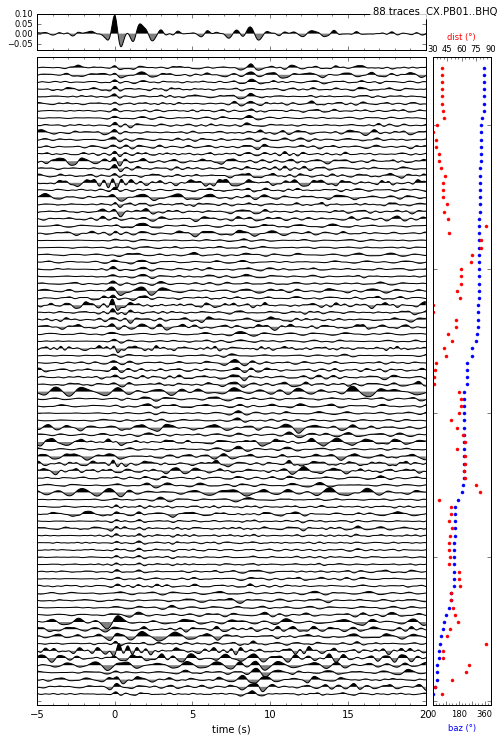

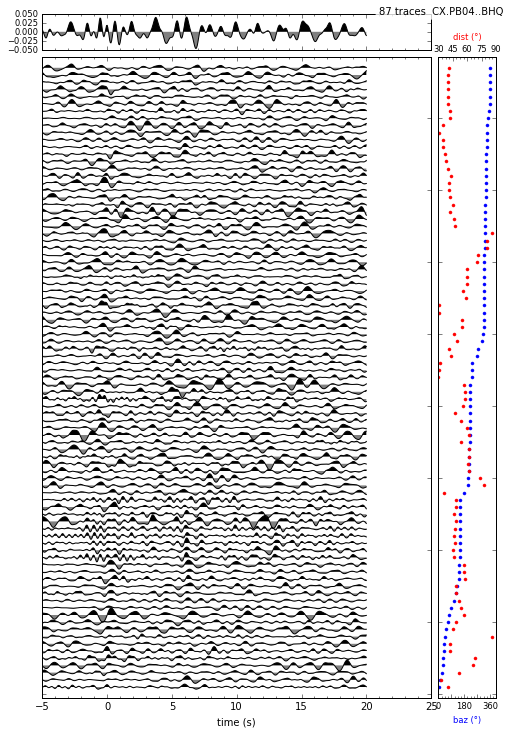

In [6]:
stream = read_rf(rffile, 'H5')
kw = {'trim': (-5, 20), 'fillcolors': ('black', 'gray'), 'trace_height': 0.1}
stream.select(component='L', station='PB01').sort(['back_azimuth']).plot_rf(**kw)
for sta in ('PB01', 'PB04'):
    stream.select(component='Q', station=sta).sort(['back_azimuth']).plot_rf(**kw)

Finally, we stack receiver functions by piercing point longitude in 70km depth and plot the resulting profile. The `get_profile_boxes` function is used to define the domains for stacking. The azimuth is 90 degreee to define an West-East profile. The domains are plotted with `plot_profile_map`. The profile is generated by the `profile` function. Using the `profile` function instead of the `RFStream.profile` method allows to display a progressbar (and it is also possible to directly feed rf data from disc for large datasets).

213 Trace(s) in Stream:

Prf profile (L) | -25.0s - 75.0s | 20.0 Hz, 2001 samples | pos:1.25km slow:6.40 (Ps moveout)
...
(211 other traces)
...
Prf profile (T) | -25.0s - 75.0s | 20.0 Hz, 2001 samples | pos:178.75km slow:6.40 (Ps moveout)

[Use "print(Stream.__str__(extended=True))" to print all Traces]


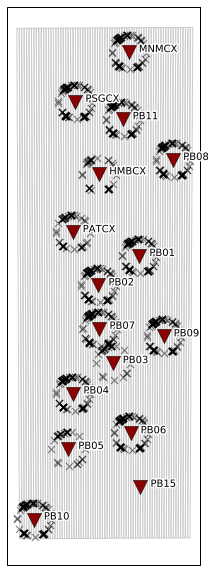

In [7]:
stream = read_rf(rffile, 'H5')
ppoints = stream.ppoints(70)
boxes = get_profile_boxes((-21.3, -70.7), 90, np.linspace(0, 180, 73), width=530)
plt.figure(figsize=(10, 10)); plot_profile_map(boxes, inventory=inventory, ppoints=ppoints)
pstream = profile(tqdm(stream), boxes)
pstream.write(profilefile, 'H5')
print pstream    

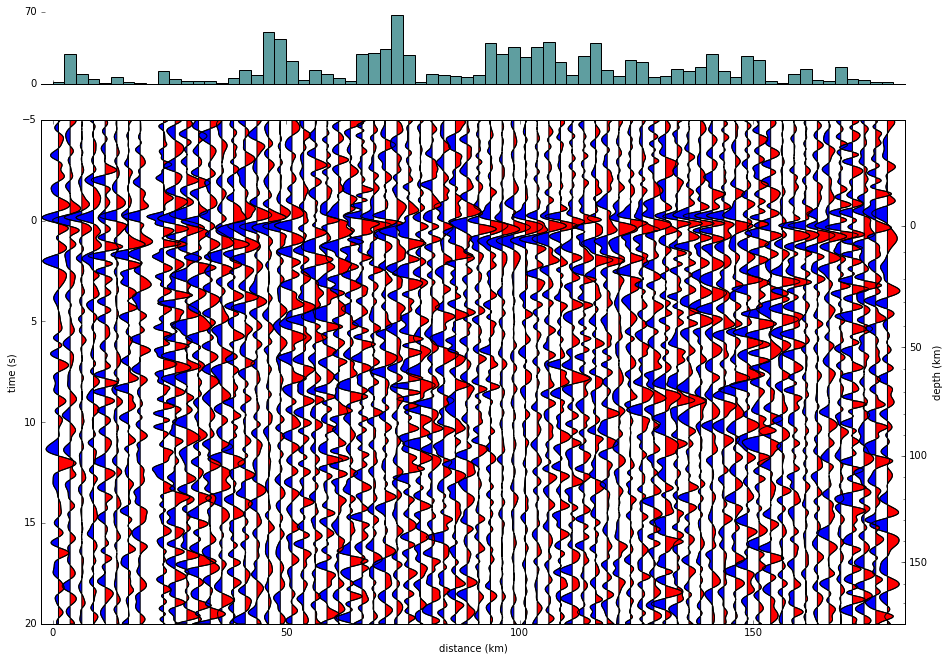

In [8]:
pstream = read_rf(profilefile)
pstream.trim2(-5, 20, 'onset')
pstream.select(channel='??Q').normalize().plot_profile(scale=1.5, top='hist')
plt.gcf().set_size_inches(15, 10)

That's it. With little imagination we can identify an interface corresponding to the subducting Nasca plate. To make the image more clear we could define some kind of quality control ideally before the deconvolution. A simple signal-to-noise ratio would be fine for the beginning. By the way, another good visualization technique is migration. If you have a good rf migration code you want to share, feel free to open an issue on the rf project page on GitHub or contact the developer(s) directly.